# Coordinate Query

This notebook demonstrates how to query the survey for datacubes based on a coordinate.

In [1]:
import os.path as op
import numpy as np
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
pdr1_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/'
decompressed_dir = '/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed'
ifu_data = Table.read(op.join( pdr1_dir, 'ifu-index.fits'))

In [3]:
# Create SkyCoord Object array for IFU centers
ifu_coords = SkyCoord( ra=ifu_data['ra_cen']*u.deg, dec=ifu_data['dec_cen']*u.deg)

## Single Coordinate Search

This is an AGN galaxy observed multiple times

In [4]:
coord = SkyCoord(ra=150.23189*u.deg, dec=2.363963*u.deg)

In [5]:
# find list of possible datacubes with coverage
sel = coord.separation( ifu_coords) < 26*u.arcsec

In [6]:
# this AGN is observed 9 times
ifu_data[sel]

shotid,ifuslot,ra_cen,dec_cen,flag,flag_badamp,flag_badfib,flag_meteor,flag_satellite,flag_shot,flag_throughput,field,objid,date,obsid,ra_shot,dec_shot,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra
int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32
20181118020,036,150.23578,2.359445,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcosb1_E,20181118,20,150.198857,2.287554,148.024161,45,1.6654317,0.22705695,0.132,7.581111,20181118v020,-6.7472224,427.39902,31.657,58440.484,26,1,803.65765,140.20572,1136061,2.2875,146.57367,150.1995
20181119015,036,150.23572,2.359491,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcosb2_E,20181119,15,150.198814,2.287591,148.009643,45,1.2585844,0.08676765,0.1321,9.3122225,20181119v015,-5.2355556,487.71655,33.139,58441.465,28,1,803.0142,140.18245,1107385,2.2875,146.55505,150.1995
20181119016,036,150.23572,2.35951,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcosb3_E,20181119,16,150.198811,2.287611,148.011715,45,1.2,0.0,0.1168,9.078889,20181119v016,-5.133333,367.99936,33.986,58441.484,25,1,803.0142,140.18245,1136316,2.2875,146.55505,150.1995
20181120012,036,150.23576,2.359472,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcosb4_E,20181120,12,150.198854,2.287567,148.001885,45,1.8817229,0.3503828,0.1567,3.3877778,20181120v012,-0.44,487.7499,85.628,58442.46,26,1,806.299,140.18256,1105403,2.2875,146.55513,150.1995
20181120013,036,150.23575,2.359488,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcosb5_E,20181120,13,150.198844,2.287584,148.003967,45,1.8901759,0.23786451,0.1527,3.3605556,20181120v013,-0.32777777,427.7664,88.785,58442.48,28,1,806.299,140.18256,1134013,2.2875,146.55513,150.1995
20220130020,024,150.22855,2.367442,1.0,1.0,1.0,1.0,1.0,1.0,1.0,cosmos,DEXcs0001b,20220130,20,150.138553,2.327438,147.835886,76,2.5802982,0.16564429,0.1839,5.1966667,20220130v020,-2.443889,607.6802,62.597,59609.266,19,1,-99898.45,140.05551,0623043,2.327694,146.4535,150.13959
20220131010,040,150.23387,2.368383,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcs0007,20220131,10,150.272346,2.494516,215.426593,76,1.8608696,0.19882418,0.1619,4.8116665,20220131v010,-5.592222,427.92456,45.017,59610.4,33,1,-99898.45,220.46906,0935048,2.493989,213.9665,150.27328
20240310015,070,150.23264,2.365394,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcs0031a,20240310,15,150.339282,2.443389,215.365136,77,1.7754945,0.3222561,0.1385,2.1772223,20240310v015,-4.8072224,667.16595,57.644,60379.28,30,1,802.2015,220.31386,0643191,2.443819,213.84248,150.33896
20240313016,070,150.23264,2.365384,0.998,1.0,0.998,1.0,1.0,1.0,1.0,cosmos,DEXcs0031a,20240313,16,150.339272,2.443392,215.358206,77,1.8249643,0.2502434,0.1988,12.839444,20240313v016,-11.375,547.84924,15.943,60382.273,29,1,798.03625,220.31686,0636162,2.443819,213.8449,150.33896


In [7]:
# data cube paths?
for row in ifu_data[sel]:
    shotid = row['shotid']
    ifuslot= row['ifuslot']
    datacube_path = op.join( pdr1_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))
    print( datacube_path)

/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20181118020/dex_cube_20181118020_036.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20181119015/dex_cube_20181119015_036.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20181119016/dex_cube_20181119016_036.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20181120012/dex_cube_20181120012_036.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20181120013/dex_cube_20181120013_036.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20220130020/dex_cube_20220130020_024.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20220131010/dex_cube_20220131010_040.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20240310015/dex_cube_20240310015_070.fits
/home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/datacubes/20240313016/dex_cube_20240313016_070.fits


Let's extract 1D spectra at the source coordinate. We'll do just one to start.

In [8]:
shotid = ifu_data['shotid'][sel][0]
ifuslot= ifu_data['ifuslot'][sel][0]
datacube_path = op.join( pdr1_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))
hdul = fits.open( datacube_path)
header = hdul["DATA"].header
wcs = WCS(header)

In [9]:
# WCS info is stored here
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN' 'DEC--TAN' 'WAVE' 
CRVAL : 150.23577880859 2.3594448566437 3470.0 
CRPIX : 52.0 52.0 1.0 
PC1_1 PC1_2 PC1_3  : -0.50642268529106 0.86228537261314 0.0 
PC2_1 PC2_2 PC2_3  : -0.86228537261314 -0.50642268529106 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : -0.00013888888888889 0.00013888888888889 2.0 
NAXIS : 104  104  1036

In [10]:
# wcs for spatial dimensions can be accessed through
wcs.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 150.23577880859 2.3594448566437 
CRPIX : 52.0 52.0 
PC1_1 PC1_2  : -0.50642268529106 0.86228537261314 
PC2_1 PC2_2  : -0.86228537261314 -0.50642268529106 
CDELT : -0.00013888888888889 0.00013888888888889 
NAXIS : 104  104

In [11]:
flux = hdul["DATA"].data
error = hdul["ERROR"].data
mask = hdul["MASK"].data
data_mask = np.where( (mask > 0) | (flux == 0) )

# apply data_mask using fill value NaN
flux[ data_mask ] = np.nan
error[ data_mask ] = np.nan


In [12]:
r_arcsec = 2.0  # aperture radius in arcseconds

# Get pixel coordinates of center
x_pix, y_pix = wcs.celestial.world_to_pixel(coord)
x_pix, y_pix = float(x_pix), float(y_pix)  # keep float for sub-pixel centering

# Compute pixel scale (assume square pixels)
pixel_scale = np.abs(wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value  #pixel scale in arcsec
r_pix = r_arcsec / pixel_scale

In [13]:
# Create circular aperture mask (returns Boolean array)
ny, nx = flux.shape[1:]
yy, xx = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
r2 = (xx - x_pix)**2 + (yy - y_pix)**2
circular_aperture_mask = r2 <= r_pix**2


In [14]:
# Apply circular aperture_mask and sum up flux 
spectrum = np.nansum( flux[:, circular_aperture_mask], axis=1 )

In [15]:
spectrum[ spectrum == 0] = np.nan

In [16]:
# access wavelength information from wcs
wcs_spectral = WCS(header).sub(['spectral'])
wavelengths = wcs_spectral.pixel_to_world(np.arange(flux.shape[0])).value

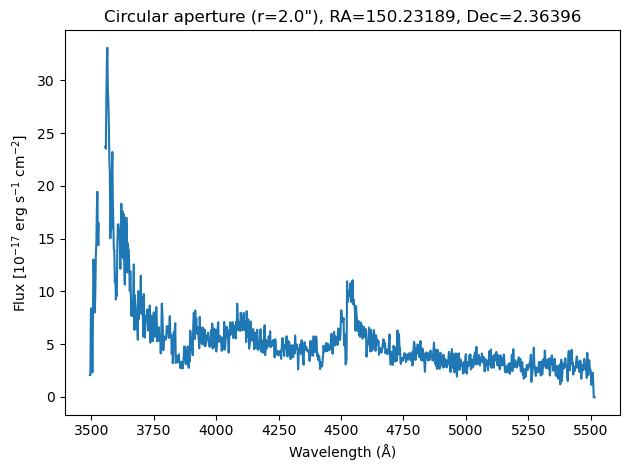

In [17]:
plt.plot(wavelengths, spectrum)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]")
plt.title(f"Circular aperture (r={r_arcsec:.1f}\"), RA={coord.ra.deg:.5f}, Dec={coord.dec.deg:.5f}")
plt.tight_layout()
plt.show()


## Now plot all spectra for same source

In [18]:
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 14})

plt.rcParams['lines.linewidth'] = 2

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.labelsize']= 12.0
plt.rcParams['ytick.labelsize']= 12.0

This time we'll point to the path where we have already decompressed the datacubes so the read time will be faster. See notebook 08-BatchDecompression.ipynb for how to decompress download FITS cubes.

Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181118020/dex_cube_20181118020_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181119015/dex_cube_20181119015_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181119016/dex_cube_20181119016_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181120012/dex_cube_20181120012_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181120013/dex_cube_20181120013_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20220130020/dex_cube_20220130020_024.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20220131010/dex_cube_20220131010_040.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20

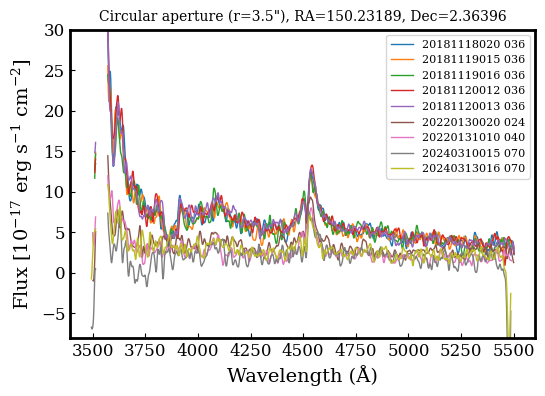

In [19]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(6,4))

for row in ifu_data[sel]:
    shotid = row['shotid']
    ifuslot= row['ifuslot']
    datacube_path = op.join( decompressed_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))
    print('Working on', datacube_path)
    
    # --- Load cube and WCS ---
    with fits.open(datacube_path, memmap=False) as hdul:
        header = hdul["DATA"].header
        flux = hdul["DATA"].data  # shape (nz, ny, nx)
        mask = hdul["MASK"].data
        #mask where bitmask is flagged non-zero and if flux is 0
        data_mask = np.where( (mask > 0) | (flux == 0))
                
        # apply mask using fill value NaN
        flux[ data_mask ] = np.nan
        wcs = WCS(header)

    r_arcsec = 3.5  # aperture radius in arcseconds

    # Get pixel coordinates of center
    x_pix, y_pix = wcs.celestial.world_to_pixel(coord)
    x_pix, y_pix = float(x_pix), float(y_pix)  # keep float for sub-pixel centering
    
    # Compute pixel scale (assume square pixels)
    pixel_scale = np.abs(wcs.proj_plane_pixel_scales()[0]).to(u.arcsec).value  #pixel scale in arcsec
    r_pix = r_arcsec / pixel_scale

    # Create circular aperture mask (returns Boolean array)
    ny, nx = flux.shape[1:]
    yy, xx = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
    r2 = (xx - x_pix)**2 + (yy - y_pix)**2
    circular_aperture_mask = r2 <= r_pix**2

    # Apply circular aperture_mask and sum up flux 
    spectrum = np.nansum( flux[:, circular_aperture_mask], axis=1 )
    spectrum[ spectrum == 0] = np.nan
    
    # access wavelength information from wcs
    wcs_spectral = WCS(header).sub(['spectral'])
    wavelengths = wcs_spectral.pixel_to_world(np.arange(flux.shape[0])).value
    #plt.plot(wavelengths, spectrum, lw=0.5, label='{} {}'.format(shotid, ifuslot))
    smoothed_spec = gaussian_filter1d(spectrum, sigma=2)  # Adjust sigma for smoothing strength
    plt.plot(wavelengths, smoothed_spec, lw=1, label='{} {}'.format(shotid, ifuslot))

    
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]")
plt.title(f"Circular aperture (r={r_arcsec:.1f}\"), RA={coord.ra.deg:.5f}, Dec={coord.dec.deg:.5f}", fontsize=10)
plt.legend(fontsize=8, loc='upper right')
plt.ylim(-8, 30)
plt.savefig('changing_agn_spec.png', dpi=150)


### Cool! We've discovered this is a changing look AGN

For fun let's take what we learned in 07-CollapsingCubes.ipynb and explore the line flux maps. This time we'll use astropy's handy Cutout2D function

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch, LogStretch
from astropy.nddata import Cutout2D
from astropy.wcs.utils import proj_plane_pixel_scales, skycoord_to_pixel

In [21]:
lya_center = 3563

zoom_radius_arcsec = 10
cutout_size_arcsec = 2 * zoom_radius_arcsec
cutout_fill_value = np.nan

cutouts_cont = []
cutouts_nb = []
titles = []
wcss = []

for idx, row in enumerate(ifu_data[sel][:9]):  # limit to 9 for 3x3
    shotid = row['shotid']
    ifuslot= row['ifuslot']
    datacube_path = op.join( decompressed_dir, 'datacubes', str(shotid), 'dex_cube_{}_{}.fits'.format( shotid, ifuslot))
    print('Working on', datacube_path)
    
    # --- Load cube and WCS ---
    with fits.open(datacube_path, memmap=False) as hdul:
        header = hdul["DATA"].header
        flux = hdul["DATA"].data  # shape (nz, ny, nx)
        mask = hdul["MASK"].data
        #mask where bitmask is flagged non-zero and if flux is 0
        data_mask = np.where( (mask > 0) | (flux == 0))
        
        # apply mask using fill value NaN
        flux[ data_mask ] = np.nan
        wcs = WCS(header)
        wcs_celestial = wcs.celestial
        wave = WCS(header).sub(['spectral']).pixel_to_world(np.arange(flux.shape[0])).value

    # Collapse around Lyman-alpha
    z_index_nb = np.abs(3563 - wave) < 50
    flux_nb = np.nansum(flux[z_index_nb, :, :], axis=0)

    # Collapse continuum
    z_index_cont = (wave >= 3800) & (wave <= 5200)
    flux_cont = np.nansum(flux[z_index_cont, :, :], axis=0)

    # Get pixel size
    arcsec_per_pixel = proj_plane_pixel_scales(wcs.celestial)[0] * u.deg
    arcsec_per_pixel = arcsec_per_pixel.to(u.arcsec).value
    
    size_pix = int(np.round(cutout_size_arcsec / arcsec_per_pixel))

    # Create square cutouts with fill_value padding if needed
    cut_nb = Cutout2D(flux_nb, coord, size=(size_pix, size_pix),
                      wcs=wcs.celestial, mode='partial', fill_value=cutout_fill_value)
    cut_cont = Cutout2D(flux_cont, coord, size=(size_pix, size_pix),
                        wcs=wcs.celestial, mode='partial', fill_value=cutout_fill_value)

    cutouts_nb.append(cut_nb.data)
    cutouts_cont.append(cut_cont.data)
    titles.append(f"{shotid}-{ifuslot}")
    wcss.append(cut_cont.wcs)


Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181118020/dex_cube_20181118020_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181119015/dex_cube_20181119015_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181119016/dex_cube_20181119016_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181120012/dex_cube_20181120012_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20181120013/dex_cube_20181120013_036.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20220130020/dex_cube_20220130020_024.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20220131010/dex_cube_20220131010_040.fits
Working on /home/jovyan/Hobby-Eberly-Public/HETDEX/internal/pdr1/decompressed/datacubes/20

In [22]:
# Compute global display limits
interval = PercentileInterval(90)
all_cont_data = np.concatenate([np.ravel(c) for c in cutouts_cont])
all_nb_data = np.concatenate([np.ravel(c) for c in cutouts_nb])

vmin_cont, vmax_cont = interval.get_limits(all_cont_data[np.isfinite(all_cont_data)])
vmin_nb, vmax_nb = interval.get_limits(all_nb_data[np.isfinite(all_nb_data)])

norm_cont = ImageNormalize(vmin=vmin_cont, vmax=vmax_cont, stretch=SqrtStretch())
norm_nb = ImageNormalize(vmin=vmin_nb, vmax=vmax_nb, stretch=LogStretch())


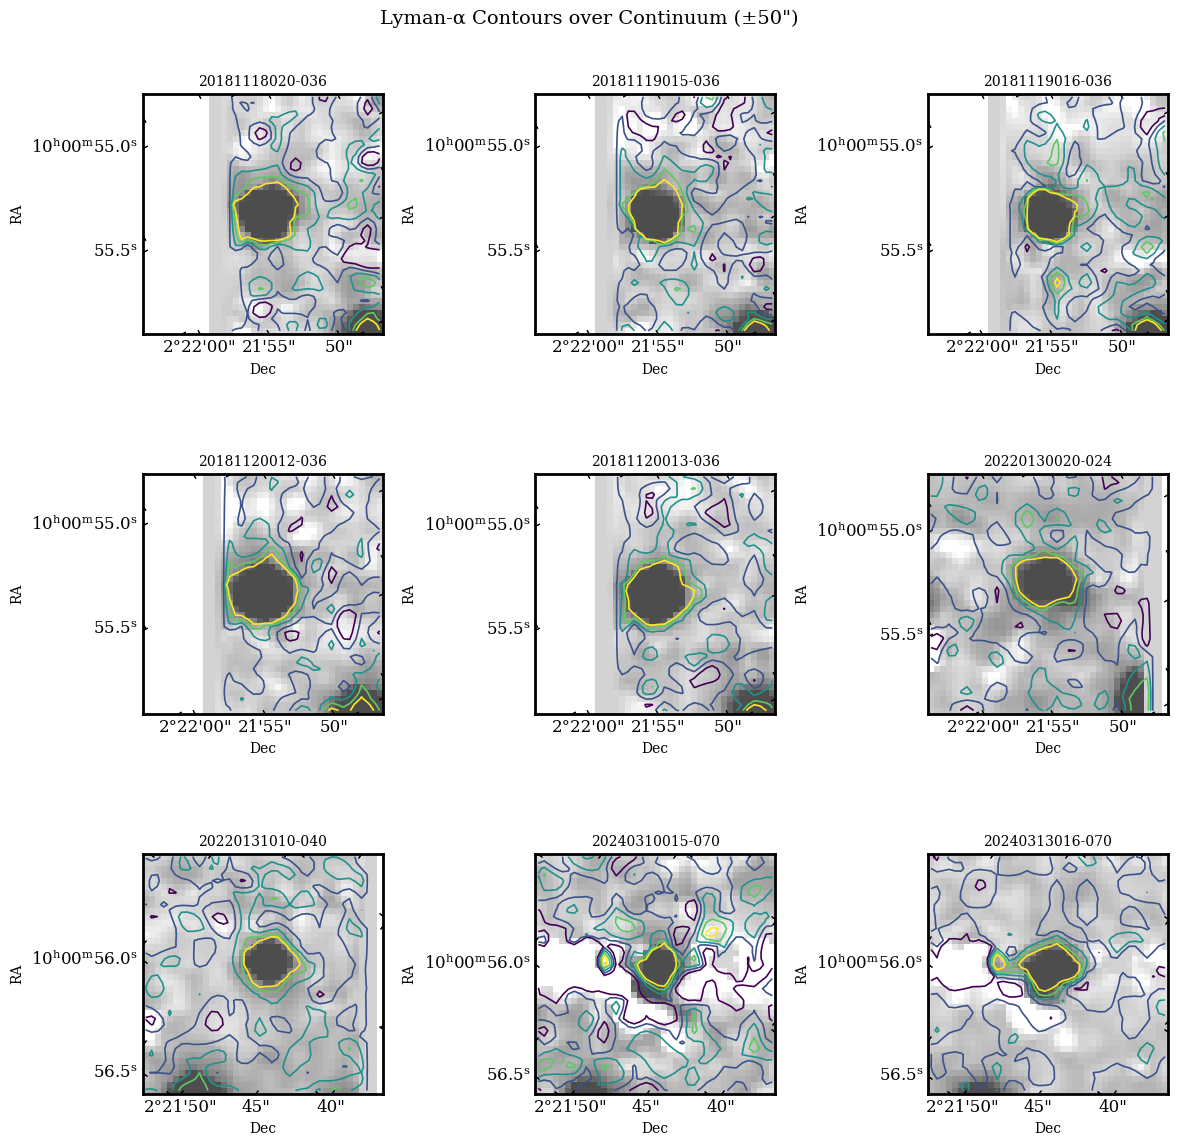

In [24]:
fig = plt.figure(figsize=(12, 12))
n_panels = len(cutouts_nb)

for idx in range(n_panels):
    ax = fig.add_subplot(3, 3, idx + 1, projection=wcss[idx])

    ax.imshow(cutouts_cont[idx], origin='lower', cmap='Greys', norm=norm_cont, alpha=0.7)

    levels = np.linspace(vmin_nb, vmax_nb, 5)
    ax.contour(cutouts_nb[idx], levels=levels, cmap='viridis', linewidths=1.2)
    
    ax.coords[1].set_axislabel('Dec', fontsize=10)
    ax.coords[0].set_axislabel('RA', fontsize=10)

    ax.set_title(titles[idx], fontsize=10)
    ax.coords.grid(False)

plt.suptitle("Lyman-α Contours over Continuum (±50\")", fontsize=14)
plt.tight_layout()
plt.savefig('changing_agn.png', dpi=150)